## Sentiment Analysis Interpreter
We train a simple transformer for sentiment analysis on movie reviews, extract interpretable features using SAE and generate explanations using LLMs.

#### Imports

In [38]:
import os
from dataPreprocessing import *
import pandas as pd
from torch.utils.data.dataset import random_split
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

##### Global Constants

In [39]:
RANDOM_SEED = 42
BATCH_SIZE = 64
from dataPreprocessing import PADDING_VALUE, UNK_VALUE
torch.manual_seed(RANDOM_SEED)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else('mps' if torch.backends.mps.is_available() else 'cpu'))
print(device)

mps


In [41]:
def save_checkpoint(model, model_name, loss_fn='ce'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    os.makedirs(os.path.join(os.getcwd(), 'model_weights'), exist_ok=True)
    checkpoint = { # create a dictionary with all the state information
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved to {file_path}")

def load_checkpoint(model, model_name, loss_fn='ce', map_location='cpu'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure correct device
    model.load_state_dict(checkpoint['model_state_dict'])

In [42]:
def plot_loss(train_loss_over_time, val_loss_over_time, model_name):
    epochs = range(1, len(train_loss_over_time) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_over_time, color='red', label='Train Loss')
    plt.plot(epochs, val_loss_over_time, color='blue', label='Val Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Data Preprocessing

##### Load Data
Data is loaded from 'dataset' folder. There are 50,000 reviews in the data total. 25,000 for training and 25,000 testing. Reviews have label, either positive or negative. There are an equal number of positive and negative reviews in the each dataset. Each review is a text file.

In [43]:
#folder path were dataset is located
path = 'dataset/'
#initialize empty lists to hold data
train_pos, train_neg, test_pos, test_neg = [], [], [], []
#create a dictionary where the key is the relative path to data and value is empty list
sets_dict = {'train/pos/': train_pos, 'train/neg/': train_neg, 'test/pos/': test_pos, 'test/neg/': test_neg}
#loop through dictionary to read from files and populate empty lists
for dataset in sets_dict:
        file_list = [file for file in next(os.walk(os.path.join(path, dataset)))[2] if file.endswith('.txt')]
        file_list = sorted(file_list)
        load_data(os.path.join(path, dataset), file_list, sets_dict[dataset])
#Covert lists to pandas dataframes and combine to form train and test datasets
train_data = pd.concat([pd.DataFrame({'review': train_pos, 'label':1}), pd.DataFrame({'review': train_neg, 'label':0})], axis = 0, ignore_index=True)
test_data = pd.concat([pd.DataFrame({'review': test_pos, 'label':1}), pd.DataFrame({'review': test_neg, 'label':0})], axis = 0, ignore_index=True)

In [44]:
#Visualize train_data dataframe
print(train_data.shape)
print(train_data.head())
print(train_data.tail())

(25000, 2)
                                              review  label
0  Bromwell High is a cartoon comedy. It ran at t...      1
1  Homelessness (or Houselessness as George Carli...      1
2  Brilliant over-acting by Lesley Ann Warren. Be...      1
3  This is easily the most underrated film inn th...      1
4  This is not the typical Mel Brooks film. It wa...      1
                                                  review  label
24995  Towards the end of the movie, I felt it was to...      0
24996  This is the kind of movie that my enemies cont...      0
24997  I saw 'Descent' last night at the Stockholm Fi...      0
24998  Some films that you pick up for a pound turn o...      0
24999  This is one of the dumbest films, I've ever se...      0


In [45]:
#Visualize test_data dataframe
print(test_data.shape)
print(test_data.head())
print(test_data.tail())

(25000, 2)
                                              review  label
0  I went and saw this movie last night after bei...      1
1  Actor turned director Bill Paxton follows up h...      1
2  As a recreational golfer with some knowledge o...      1
3  I saw this film in a sneak preview, and it is ...      1
4  Bill Paxton has taken the true story of the 19...      1
                                                  review  label
24995  I occasionally let my kids watch this garbage ...      0
24996  When all we have anymore is pretty much realit...      0
24997  The basic genre is a thriller intercut with an...      0
24998  Four things intrigued me as to this film - fir...      0
24999  David Bryce's comments nearby are exceptionall...      0


##### Tokenize Data
Tokenize each review using spacy english tokenizer

In [46]:
train_data["tokenized"] = train_data["review"].apply(lambda x: tokenize(clean_text(x.lower())))
test_data["tokenized"] = test_data["review"].apply(lambda x: tokenize(clean_text(x.lower())))

In [47]:
#Examine tokenized reviews
print(train_data.head()["tokenized"])

0    [bromwell, high, is, a, cartoon, comedy, ., it...
1    [homelessness, (, or, houselessness, as, georg...
2    [brilliant, over, -, acting, by, lesley, ann, ...
3    [this, is, easily, the, most, underrated, film...
4    [this, is, not, the, typical, mel, brooks, fil...
Name: tokenized, dtype: object


In [48]:
max = 0
total = 0
above_thresh = 0
for review in train_data["tokenized"]:
  if len(review) > max:
    max = len(review)
  total += len(review)
  if len(review) > 800:
    above_thresh += 1
print(max)
print(total/25000)
print(above_thresh)

2772
273.77724
843


##### Voacb Map
Create a vocab map 

In [49]:
train_vocab, reversed_train_vocab = generate_vocab_map(train_data)

In [50]:
len(train_vocab)

38412

##### Building Pytorch Dataset

In [51]:
generator1 = torch.Generator().manual_seed(RANDOM_SEED)

train_dataset = ReviewDataset(train_vocab, train_data)
train_dataset, val_dataset = random_split(train_dataset,[0.9,0.1], generator=generator1)
test_dataset  = ReviewDataset(train_vocab, test_data)

train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)
test_sampler  = RandomSampler(test_dataset)

##### Pytorch DataLoader

In [52]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

In [64]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class SimpleSentimentTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dropout=0.1):
        super(SimpleSentimentTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = nn.Embedding(400, embed_dim)
        encoder_layers = TransformerEncoderLayer(embed_dim, num_heads, dim_feedforward=embed_dim, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(embed_dim, 2)
        self.dropout = nn.Dropout(dropout)
        
    def generate_padding_mask(self, src, padding_idx=0):
        padding_mask = (src == padding_idx)
        return padding_mask

    def forward(self, x, padding_idx=0):
        padding_mask = self.generate_padding_mask(x, padding_idx)
        seq_length = x.size(1)
        pos = torch.arange(0, seq_length).unsqueeze(0).repeat(x.size(0), 1).to(x.device)
        x = self.embedding(x) + self.pos_encoder(pos)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)
        avg_mask = ~padding_mask
        avg_mask = avg_mask.permute(1, 0).float().unsqueeze(-1)
        x = x * avg_mask
        x = x.sum(dim=0) / avg_mask.sum(dim=0).clamp(min=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def train_batch(model, data, targets, padding_idx=0):
    outputs = model(data, padding_idx)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, targets)
    return loss

In [54]:
def get_accuracy_and_f1_score(y_true, y_predicted):
    """
    This function takes in two numpy arrays and computes the accuracy and F1 score
    between them. You can use the imported sklearn functions to do this.

    Args:
        y_true (list) : A 1D numpy array of ground truth labels
        y_predicted (list) : A 1D numpy array of predicted labels

    Returns:
        accuracy (float) : The accuracy of the predictions
        f1_score (float) : The F1 score of the predictions
    """

    accuracy = accuracy_score(y_true, y_predicted)

    f1 = f1_score(y_true, y_predicted, average='macro')

    return accuracy, f1

In [55]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()

In [56]:
def get_criterion(loss_type='ce'):
    criterion = None

    ## YOUR CODE STARTS HERE ##
    if loss_type == 'ce':
        criterion = nn.CrossEntropyLoss()

    ## YOUR CODE ENDS HERE ##

    return criterion

In [57]:
def get_optimizer(model, learning_rate):
    """
    This function takes a model and a learning rate, and returns an optimizer.
    Feel free to experiment with different optimizers.
    """
    optimizer = None

    ## YOUR CODE STARTS HERE ##
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ## YOUR CODE ENDS HERE ##

    return optimizer

In [58]:
def train_loop(model, criterion, optimizer, iterator, epoch, save_every=10):
    """
    This function is used to train a model for one epoch.
    :param model: The model to be trained
    :param criterion: The loss function
    :param optim: The optimizer
    :param iterator: The training data iterator
    :return: The average loss for this epoch
    """
    model.train() # Is used to put the model in training mode
    total_loss = 0
    for x, y in tqdm(iterator, total=len(iterator), desc="Training Model"):
        ### YOUR CODE STARTS HERE ###
        # remove this when you add your implementation
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)

        # output = output.long()
        y = y.long()

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        ### YOUR CODE ENDS HERE ###

    average_loss = total_loss / len(iterator)
    return average_loss

In [59]:
def val_loop(model, criterion, iterator):
    """
    This function is used to evaluate a model on the validation set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    for x, y in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
         # remove this when you add your implementation
         x, y = x.to(device), y.to(device)
         output = model(x)

        #  output = output.long()
         y = y.long()

         loss = criterion(output, y)

         total_loss += loss.item()
         true.extend(y.tolist())
         predicted = torch.argmax(output, dim=1)
         pred.extend(predicted.tolist())


    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

In [60]:
def test_loop(model, criterion, iterator):
    """
    This function is used to evaluate a model on the test set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    for x, y in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
         # remove this when you add your implementation
         x, y = x.to(device), y.to(device)
         output = model(x)

        #  output = output.long()
         y = y.long()

         loss = criterion(output, y)

         total_loss += loss.item()
         true.extend(y.tolist())
         predicted = torch.argmax(output, dim=1)
         pred.extend(predicted.tolist())


    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

In [61]:
def get_hyperparams_transformer():
    VOCAB_SIZE = len(train_vocab)
    EMBED_DIM = 4
    NUM_HEADS = 1
    NUM_LAYERS = 1
    DROPOUT = 0.1
    LEARNING_RATE = 0.015
    EPOCHS = 2
    return VOCAB_SIZE, EMBED_DIM, NUM_HEADS, NUM_LAYERS, DROPOUT, LEARNING_RATE, EPOCHS

In [62]:
def get_transformer_model(vocab_size, embedding_dim, num_heads, num_layers, dropout):
    model = SimpleSentimentTransformer(
        vocab_size=vocab_size,
        embed_dim=embedding_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        dropout=dropout
    )
    return model

In [65]:
VOCAB_SIZE, EMBED_DIM, NUM_HEADS, NUM_LAYERS, DROPOUT, LEARNING_RATE, EPOCHS = get_hyperparams_transformer()

transformer_model = get_transformer_model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

criterion = get_criterion()
optimizer = get_optimizer(transformer_model, LEARNING_RATE)
train_loss_over_time_transformer = []
val_loss_over_time_transformer = []

for epoch in range(EPOCHS):
    train_loss = train_loop(transformer_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(transformer_model, criterion, val_iterator) # change to val
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
    train_loss_over_time_transformer.append(train_loss)
    val_loss_over_time_transformer.append(val_loss)
save_checkpoint(transformer_model, 'transformer2')

/Applications/miniconda3/envs/nlp_project_env/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Evaluating Model: 100%|██████████| 40/40 [00:00<00:00, 47.06it/s]


Epoch 1 -- Train_Loss: 0.4832953506318683 -- Val_Loss: 0.3282777536660433 -- Val_Accuracy: 0.868 -- Val_F1: 0.8679834398426938


Evaluating Model: 100%|██████████| 40/40 [00:00<00:00, 51.97it/s]


Epoch 2 -- Train_Loss: 0.2358433048621836 -- Val_Loss: 0.31322788801044227 -- Val_Accuracy: 0.876 -- Val_F1: 0.8759135166845885
Checkpoint saved to /Users/sunidhidhawan/Downloads/NLP/Sentiment-Analysis-Intepreter/model_weights/checkpoint_transformer2_ce.pt


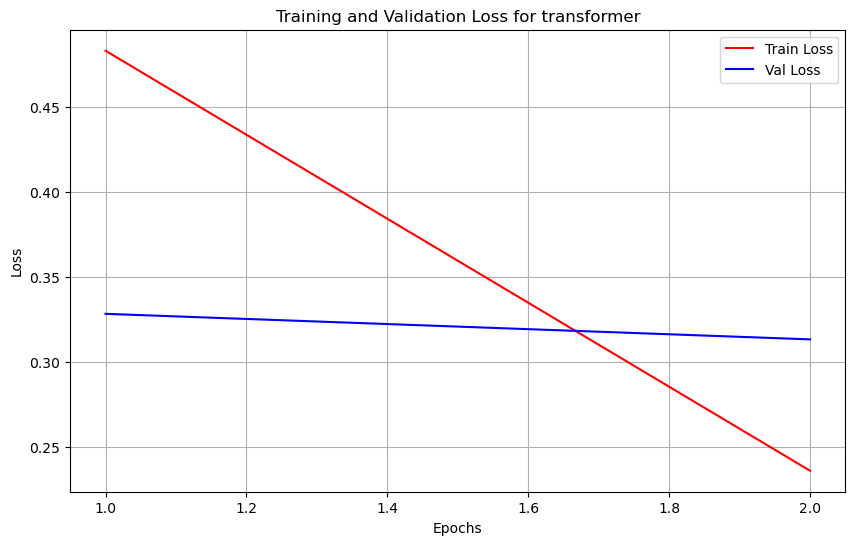

In [66]:
plot_loss(train_loss_over_time_transformer, val_loss_over_time_transformer, 'transformer')

In [ ]:
transformer_model

SimpleSentimentTransformer(
  (embedding): Embedding(38412, 4)
  (pos_encoder): Embedding(400, 4)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (linear1): Linear(in_features=4, out_features=4, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=4, out_features=4, bias=True)
        (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=4, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [67]:
VOCAB_SIZE, EMBED_DIM, NUM_HEADS, NUM_LAYERS, DROPOUT, LEARNING_RATE, EPOCHS = get_hyperparams_transformer()

transformer_model = get_transformer_model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)
load_checkpoint(transformer_model, 'transformer2', map_location=device)

# evaluate model
true, pred, val_loss = test_loop(transformer_model, criterion, test_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Test Accuracy: {accuracy}")
print(f"Final Test F1-Score: {f1}")

/Applications/miniconda3/envs/nlp_project_env/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Evaluating Model: 100%|██████████| 391/391 [00:07<00:00, 50.51it/s]

Final Test Accuracy: 0.85888
Final Test F1-Score: 0.8585951803760841


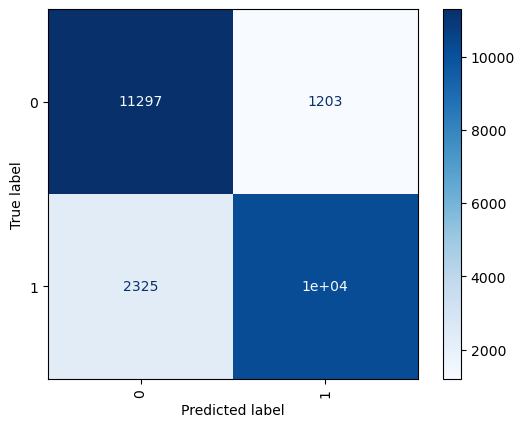

In [68]:
plot_confusion_matrix(true, pred, classes=[0, 1])

In [69]:
pytorch_total_params = sum(p.numel() for p in transformer_model.parameters())
print(pytorch_total_params)

155394


### Analyze Transformer Weights

In [70]:
checkpoint = torch.load("model_weights/checkpoint_transformer_ce.pt", map_location='cpu')
checkpoint

{'model_state_dict': OrderedDict([('embedding.weight',
               tensor([[ 0.0634,  0.0976,  0.1822,  0.0974],
                       [ 0.2545, -0.1711,  0.5143,  0.4379],
                       [-0.8580, -0.6819, -1.4091,  0.4607],
                       ...,
                       [-0.7168,  0.2703,  1.6081, -0.7156],
                       [ 0.6357,  0.1194, -1.0542, -0.4397],
                       [ 0.9718, -1.4879, -0.2766, -2.5030]])),
              ('pos_encoder.weight',
               tensor([[ 0.2556, -1.6277,  0.5822, -0.3424],
                       [ 0.3629,  0.8627, -0.3700,  0.0931],
                       [ 0.2821, -0.0860,  0.5397, -0.2434],
                       ...,
                       [ 1.0763,  1.4039,  0.5614,  0.3121],
                       [ 0.5904,  0.6268, -0.2063,  0.8911],
                       [ 1.6754,  0.0536, -0.7179, -0.5039]])),
              ('transformer_encoder.layers.0.self_attn.in_proj_weight',
               tensor([[ 0.0763,  0.1922, 

In [71]:
import torch
from collections import defaultdict

def analyze_specific_weights(checkpoint):
    stats = {}
    model_weights = checkpoint['model_state_dict']
    
    # Group weights by component
    groups = {
        'embedding': ['embedding.weight'],
        'positional': ['pos_encoder.weight'],
        'attention': [k for k in model_weights.keys() if 'self_attn' in k],
        'feedforward': [k for k in model_weights.keys() if 'linear' in k],
        'layer_norm': [k for k in model_weights.keys() if 'norm' in k],
        'output': [k for k in model_weights.keys() if 'fc.' in k]
    }
    
    for group_name, weight_keys in groups.items():
        print(f"\n=== {group_name.upper()} WEIGHTS ===")
        
        for key in weight_keys:
            weight = model_weights[key]
            
            # Calculate statistics
            abs_mean = torch.mean(torch.abs(weight)).item()
            std = torch.std(weight).item()
            max_val = torch.max(weight).item()
            min_val = torch.min(weight).item()
            norm = torch.norm(weight).item()
            
            print(f"\n{key}:")
            print(f"Shape: {weight.shape}")
            print(f"Magnitude stats:")
            print(f"  Mean abs value: {abs_mean:.4f}")
            print(f"  Std deviation:  {std:.4f}")
            print(f"  Min value:     {min_val:.4f}")
            print(f"  Max value:     {max_val:.4f}")
            print(f"  L2 norm:       {norm:.4f}")
            
            # Special checks for different component types
            if 'norm' in key and 'weight' in key:
                if torch.any(weight < 0):
                    print("  WARNING: Layer norm weights contain negative values!")
                    
            if 'bias' in key:
                if abs_mean > 1.0:
                    print("  WARNING: Unusually large bias values!")
                    
            if 'self_attn' in key and 'in_proj_weight' in key:
                # Check Q, K, V matrices separately
                qkv_size = weight.shape[0] // 3
                q = weight[:qkv_size]
                k = weight[qkv_size:2*qkv_size]
                v = weight[2*qkv_size:]
                print("\n  QKV breakdown:")
                print(f"  Q mean abs: {torch.mean(torch.abs(q)).item():.4f}")
                print(f"  K mean abs: {torch.mean(torch.abs(k)).item():.4f}")
                print(f"  V mean abs: {torch.mean(torch.abs(v)).item():.4f}")

# Add summary function
def print_overall_summary(checkpoint):
    model_weights = checkpoint['model_state_dict']
    total_params = sum(p.numel() for p in model_weights.values())
    max_abs = max(torch.max(torch.abs(p)).item() for p in model_weights.values())
    
    print("\n=== OVERALL MODEL SUMMARY ===")
    print(f"Total parameters: {total_params:,}")
    print(f"Maximum absolute weight value: {max_abs:.4f}")
    print("\nLayer sizes:")
    for name, param in model_weights.items():
        print(f"{name}: {param.shape}")
analyze_specific_weights(checkpoint)
# print_overall_summary(checkpoint)


=== EMBEDDING WEIGHTS ===

embedding.weight:
Shape: torch.Size([38412, 4])
Magnitude stats:
  Mean abs value: 0.9100
  Std deviation:  1.1431
  Min value:     -5.4450
  Max value:     6.0066
  L2 norm:       448.0569

=== POSITIONAL WEIGHTS ===

pos_encoder.weight:
Shape: torch.Size([400, 4])
Magnitude stats:
  Mean abs value: 0.7267
  Std deviation:  0.9150
  Min value:     -3.5781
  Max value:     3.0996
  L2 norm:       36.6285

=== ATTENTION WEIGHTS ===

transformer_encoder.layers.0.self_attn.in_proj_weight:
Shape: torch.Size([12, 4])
Magnitude stats:
  Mean abs value: 0.4335
  Std deviation:  0.5817
  Min value:     -1.4027
  Max value:     1.3793
  L2 norm:       3.9887

  QKV breakdown:
  Q mean abs: 0.1588
  K mean abs: 0.2658
  V mean abs: 0.8759

transformer_encoder.layers.0.self_attn.in_proj_bias:
Shape: torch.Size([12])
Magnitude stats:
  Mean abs value: 0.0277
  Std deviation:  0.0350
  Min value:     -0.0791
  Max value:     0.0382
  L2 norm:       0.1184

transformer_en